## Setup

### Install required libraries

The libraries should already be installed in the terminal after running 
```
pip install -r requirements.txt
```
in the root directory, but this will be useful if the notebook is used in other environments.

In [3]:
%%capture
!pip install datasets==3.6.0
!pip install transformers==4.52.4
!pip install huggingface-hub==0.32.3
!pip install torchaudio==2.7.0
!pip install librosa==0.11.0
!pip install jiwer==3.1.0
!pip install evaluate==0.4.3
!pip install matplotlib==3.10.3
!pip install jiwer==3.1.0
!pip install requests==2.32.3
!pip install huggingface-hub==0.32.3
!pip install accelerate==1.7.0

### Import required libraries

In [4]:
from datasets import Dataset, Audio, load_from_disk
import random
import evaluate
import pandas as pd
import IPython.display as ipd
import re
import json
from transformers import (Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, 
                            TrainingArguments, Trainer)
import numpy as np
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import os
import matplotlib.pyplot as plt
from jiwer import wer, cer
import requests
from huggingface_hub import configure_http_backend
import urllib3

pd.set_option('display.max_colwidth', 100)

/Users/gordon.oh/Desktop/htx-xdata-asr/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Other configurations

In [5]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# [OPTIONAL] Use if there is SSL certificate verification issues
def backend_factory() -> requests.Session:
    session = requests.Session()
    session.verify = False
    return session


configure_http_backend(backend_factory=backend_factory)

## Data Preprocessing

Instead of using ```load_dataset``` from
```
from datasets import load_dataset
```
to load Common Voice data, we load the data directly from our project directory since it is already copied inside.

### Load labels

In [6]:
dataset_split = 'cv-valid-train'
cv_csv_file = f'../datasets/common_voice/{dataset_split}.csv'
train_df = pd.read_csv(cv_csv_file)
train_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the old king had said,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dreams said the old woman,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those omens that brought you to me,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me be the first to welcome you to earth,3,2,NaN,NaN,NaN,NaN


### Clean labels' table

Make the text label uppercase because the model we are finetuning "facebook/wav2vec2-large-960h" is pretrained using Librispeech dataset, which are uppercased. Removed all the other unnecessary columns.

In [11]:
train_df['text'] = train_df['text'].str.upper()
cleaned_train_df = train_df.drop(['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'], axis=1)
audio_files_directory = f'../datasets/common_voice/{dataset_split}'
cleaned_train_df["path"] = cleaned_train_df["filename"].apply(lambda x: os.path.join(audio_files_directory, x))
cleaned_train_df.head(5)

,filename,text,path
0,cv-valid-train/sample-000000.mp3,LEARN TO RECOGNIZE OMENS AND FOLLOW THEM THE OLD KING HAD SAID,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3
1,cv-valid-train/sample-000001.mp3,EVERYTHING IN THE UNIVERSE EVOLVED HE SAID,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000001.mp3
2,cv-valid-train/sample-000002.mp3,YOU CAME SO THAT YOU COULD LEARN ABOUT YOUR DREAMS SAID THE OLD WOMAN,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000002.mp3
3,cv-valid-train/sample-000003.mp3,SO NOW I FEAR NOTHING BECAUSE IT WAS THOSE OMENS THAT BROUGHT YOU TO ME,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000003.mp3
4,cv-valid-train/sample-000004.mp3,IF YOU START YOUR EMAILS WITH GREETINGS LET ME BE THE FIRST TO WELCOME YOU TO EARTH,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000004.mp3


### Inspect text

Check if 'text' contains special characters that cannot be transcribed (eg. colon, comma, percentage, etc). We want to keep whitespaces because the model has to learn to predict when a full word is finished. If not, the output will be a sequence of characters with no spacing. Also, the apostrophes are kept because of pronounciation difference. The output shows that there is none, so the data is cleaned.

In [12]:
# This pattern keeps only rows with characters that are NOT uppercase letter, whitespace character, or a single quote '.
special_chars_pattern = r"[^A-Z\s']"

df_with_special_chars = cleaned_train_df[cleaned_train_df['text'].str.contains(special_chars_pattern, regex=True, na=False)]

print(df_with_special_chars.head(5))

Empty DataFrame
Columns: [filename, text, path]
Index: []


### Load and decode audio

In [13]:
cleaned_train_df = cleaned_train_df.rename(columns={"path": "audio"})
common_voice_train_original = Dataset.from_pandas(cleaned_train_df)
common_voice_train_temp = common_voice_train_original.cast_column("audio", Audio())

In [14]:
common_voice_train_temp[0]["audio"]

{'path': '../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3',
 'array': array([ 0.00000000e+00, -2.39675359e-13, -2.89490112e-14, ...,
         4.10622742e-04,  7.94679625e-04,  7.57523230e-04], shape=(196992,)),
 'sampling_rate': 48000}

The output of the cell above shows that the audio data is loaded with a sampling rate of 48 kHz, but 16 kHz is expected by the ```wav2vec2-large-960h``` model. Hence, we have to resample the audio data.

In [15]:
common_voice_train = common_voice_train_original.cast_column("audio", Audio(sampling_rate=16_000))

In [16]:
common_voice_train[0]["audio"]

{'path': '../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3',
 'array': array([-4.36557457e-11,  9.09494702e-12,  4.00177669e-11, ...,
         1.25038787e-04,  7.30113825e-04,  7.36902468e-04], shape=(65664,)),
 'sampling_rate': 16000}

In [17]:
common_voice_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 195776
})

### Understand the statistics of the audio sequences

The cell below calculate the 25th, 50th, and 75th percentile duration of the audio sequences. It plots the distribution as well. In order to reduce memory usage, we can let to remove top 25% of the data (~ duration >= 5 seconds).

25th percentile duration: 3.14 seconds
50th percentile duration: 4.13 seconds
75th percentile duration: 5.54 seconds




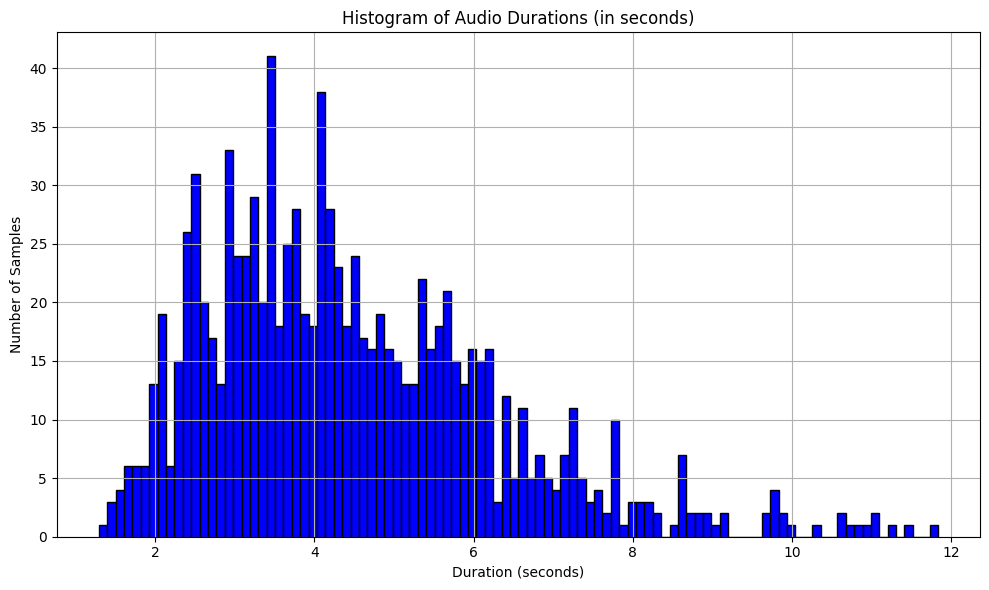

In [18]:
sample_dataset = common_voice_train[:1000]
audio_lengths = [len(sample["array"]) for sample in sample_dataset["audio"]]
sampling_rate = sample_dataset["audio"][0]["sampling_rate"]
audio_lengths_np = np.array(audio_lengths)
durations_seconds = audio_lengths_np / sampling_rate

for p in [25, 50, 75]:
    print(f"{p}th percentile duration: {np.percentile(durations_seconds, p):.2f} seconds")
print("\n")

plt.figure(figsize=(10, 6))
plt.hist(durations_seconds, bins=100, color='blue', edgecolor='black')
plt.title("Histogram of Audio Durations (in seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

### Filter out long audio sequences

Long audio sequences require a lot of memory. As the training will be done locally with limited computational resources, it is best to filter away these sequences.

In [19]:
def filter_short_audio_sequences(data, max_seconds=5):
    max_samples = 16000 * max_seconds
    return len(data["audio"]["array"]) <= max_samples

In [20]:
common_voice_train = common_voice_train.filter(filter_short_audio_sequences)

Filter: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195776/195776 [08:20<00:00, 391.42 examples/s]


In [21]:
common_voice_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 133647
})

### Check data

In [22]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["text"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])
print("\n")
ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

Target text: WHO ARE THESE PEOPLE
Input array shape: (57984,)
Sampling rate: 16000




## Tokenizer

### Building vocabulary

In Wav2Vec2 ASR models, the vocabulary is typically composed of characters or subword units, not whole words.

A user recommends characters' vocabulary:
[Wav2Vec2ForCTC fine-tuning best practices](https://github.com/huggingface/transformers/issues/15196)

We use a mapping function to build the vocabulary from the training data.

In [23]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab]}

In [24]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133647/133647 [00:00<00:00, 259444.31 examples/s]


The order of the alphabet is fixed to ensure that the input ids from the cached dataset (see later steps) can match with the vocabulary even with re-run.

In [25]:
vocab_list = list(set(vocab_train["vocab"][0]))
vocab_list.sort()
vocab_list

[' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [26]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{' ': 0,
 "'": 1,
 'A': 2,
 'B': 3,
 'C': 4,
 'D': 5,
 'E': 6,
 'F': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'J': 11,
 'K': 12,
 'L': 13,
 'M': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

To avoid ambiguity for " " token class, we give it a more visible character "|".

In [27]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

Finally, add unknown and padding tokens as well.

In [28]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
vocab_dict

{"'": 1,
 'A': 2,
 'B': 3,
 'C': 4,
 'D': 5,
 'E': 6,
 'F': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'J': 11,
 'K': 12,
 'L': 13,
 'M': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27,
 '|': 0,
 '[UNK]': 28,
 '[PAD]': 29}

Save the vocabulary file so that it can be used by the ```Wav2Vec2CTCTokenizer```.

In [29]:
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

### Instantiate the tokenizer

```Wav2Vec2CTCTokenizer``` is used because:
- The Wav2Vec2 model we are using is trained with Connectionist Temporal Classification (CTC) loss.
- Our vocabulary is character-based, which is required by CTC.
- It is compatible with ```Wav2Vec2Processor```.

In [30]:
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

## Feature Extraction

Before we can create the ```Wav2Vec2Processor``` object, we need a ```Wav2Vec2FeatureExtractor``` beside the ```Wav2Vec2CTCTokenizer```.

The following parameters for the ```Wav2Vec2FeatureExtractor``` is used:
- **feature_size**: Set to 1 as Wav2Vec2 model is trained on single-channel waveforms
- **sampling_rate**: Set to 16000 Hz to match the input data sampling rate requirement
- **padding_value**: Set to 0.0, conventional
- **do_normalize**: Set to *true* as it helps with model stability and consistency
- **return_attention_mask**: Set to *true* as Wav2Vec2 generally make use of the attention mask

### Instantiate the feature extractor

In [31]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

## Wav2Vec2 Processor

### Instantiate the processor

In [32]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Data Preparation

### Split dataset

We have to split the 'cv-valid-train' dataset further down into 70-30 ratio, where 30% is kept for validation.

In [33]:
split = common_voice_train.train_test_split(test_size=0.3, seed=42)

common_voice_train_train = split['train']
common_voice_train_validation = split['test']

Inspect the ```training_dataset```

In [34]:
common_voice_train_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 93552
})

Inspect the ```validation_dataset```

In [35]:
common_voice_train_validation

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 40095
})

### Map data to be used by processor

Inside the ```prepare_dataset``` function, more complex feature extraction methods can be added inside.

In [36]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
        
    return batch

In [37]:
training_dataset_cache_dir = "./caches/training"
validation_dataset_cache_dir = "./caches/validation"

Apply the ```prepare_dataset``` to training and validation dataset. The mapped output will be saved under the *./caches* directory. This helps to save a lot of time and memory when the notebook is re-run again. This will take a bit of time and a lot of memory...

Uncomment the cells below to prepare the data again.

In [38]:
training_dataset = common_voice_train_train.map(prepare_dataset, remove_columns=common_voice_train_train.column_names, batched=False)

Map:   0%|                                                                                                                                                                    | 0/93552 [00:00<?, ? examples/s]/Users/gordon.oh/Desktop/htx-xdata-asr/venv/lib/python3.13/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93552/93552 [10:10<00:00, 153.36 examples/s]


In [39]:
os.makedirs(training_dataset_cache_dir, exist_ok=True)
training_dataset.save_to_disk(training_dataset_cache_dir)

Saving the dataset (42/42 shards): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93552/93552 [04:29<00:00, 346.51 examples/s]


In [ ]:
validation_dataset = common_voice_train_validation.map(prepare_dataset, remove_columns=common_voice_train_validation.column_names, batched=False)

Map:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 34984/40095 [03:12<00:14, 364.13 examples/s]

In [ ]:
os.makedirs(validation_dataset_cache_dir, exist_ok=True)
validation_dataset.save_to_disk(validation_dataset_cache_dir)

### Load cached dataset

If ```training_dataset``` and ```validation_dataset``` are saved in the previous steps, we can skip the data mapping and go directly to load the dataset.

In [ ]:
training_dataset = load_from_disk(training_dataset_cache_dir)
validation_dataset = load_from_disk(validation_dataset_cache_dir)

Sanity check

In [ ]:
training_dataset

In [ ]:
validation_dataset

## Training

### Instantiate a data collator

This is taken from [transformers/.../wav2vec2/run_asr.py](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Define evaluation metrics

The predominant metric in ASR is the word error rate (WER). Character error rate (CER) is often reported as a secondary metric to show finer error details. We will show these two metrics.

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer_score = wer(label_str, pred_str)
    cer_score = cer(label_str, pred_str)

    return {"wer": wer_score, "cer": cer_score}

### Load pretrained Wav2Vec2 model

The "facebook/wav2vec2-large-960h"'s Wav2Vec2 model is selected to be finetuned with the Common Voice dataset. This pretrained model will be compared with the finetuned model later.

Rationale for the hyperparameter settings:
- Set *ctc_loss_reduction="mean"* to average the CTC loss over the batch. This normalization helps stabilize training by preventing loss values from becoming disproportionately large on longer sequences or batches, ensuring consistent gradient scales during optimization.
- Keep to default hyperparameter values as the checkpoint "facebook/wav2vec2-large-960h" already includes carefully tuned values optimized for robust training on large English speech datasets.
- Since we are training on CPU, the training speed is slower, and we cannot afford to run extensive hyperparameter tuning experiments.
- Keeping these hyperparameters at their defaults reduces complexity, training time, and the risk of destabilizing the model during finetuning.

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

### Freezing pretrained weights

Rationale for Freezing the Feature Extractor:
- The feature extractor has been pretrained on large speech data to learn robust low-level audio representations, which are generally transferable across datasets.
- Freezing it reduces the number of trainable parameters, which lowers the computational cost and speeds up training. This is important since we are using a CPU.

In [ ]:
model.freeze_feature_extractor()

### Defining training arguments

Rationale for TrainingArguments settings:
- Due to limited computational resources (using a CPU with limited memory), we set the batch size to 1 to avoid out-of-memory errors. To compensate for the small batch size and maintain effective batch gradient updates, we use a higher gradient accumulation step to simulate a larger batch size during training.
- For learning rate, weight decay, and warmup steps, we can follow [Fine-Tune Wav2Vec2 for English ASR with 🤗 Transformers](https://huggingface.co/blog/fine-tune-wav2vec2-english), which fine-tunes the base Wav2Vec2 model using another English dataset. These values are based on prior successful experiments documented there. Due to limited resources and time constraints, we will not perform an extensive hyperparameter search, and we should opt to start with these experimentally validated settings.
- *gradient_checkpointing=True* helps reduce memory usage during training.

In [ ]:
training_args = TrainingArguments(
    output_dir='./checkpoints',
    group_by_length=True,
    use_cpu=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    eval_strategy="steps",
    dataloader_num_workers=0,
    num_train_epochs=1,
    gradient_checkpointing=True,
    save_steps=2,
    eval_steps=2,
    logging_steps=2,
    learning_rate=1e-4,
    weight_decay=0.005,
    warmup_steps=1000,
    save_total_limit=2,
    push_to_hub=False,
)

In [ ]:
small_train_dataset = training_dataset.select(range(4))
small_validation_dataset = validation_dataset.select(range(4))

In [ ]:
device = torch.device("cpu")
model.to(device)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_validation_dataset,
    processing_class=processor,
)

In [ ]:
trainer.train()

## Inference

### Load finetuned model

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained('./checkpoints/checkpoint-1')
processor = Wav2Vec2Processor.from_pretrained('./checkpoints/checkpoint-1')

### Perform an inference

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

In [ ]:
input_dict = processor(validation_dataset[0]["input_values"], sampling_rate=16_000, return_tensors="pt", padding=True)
logits = model(input_dict.input_values).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

print("Prediction: ", processor.decode(pred_ids))
print("Reference: ", common_voice_train_validation[0]["text"].lower())

## Evaluation